<a href="https://colab.research.google.com/github/GVSU-CIS635/term-project-proposal-d-miner/blob/main/D_Miners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install xlrd

In [ ]:
pip install pingouin

In [ ]:
from operator import mod
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
import csv
import pingouin as pg
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, f1_score, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from re import X
CSVData = pd.read_csv('drive/My Drive/recs2020_public_v7.csv')
CSVData = pd.DataFrame(CSVData)
feature_grid = pd.read_excel('drive/My Drive/RECS 2020 Codebook for Public File - v7.xlsx', header=1)
feature_grid = pd.DataFrame(feature_grid)



In [ ]:
main_features= CSVData.columns
print(len(main_features))

none_values = [0,-2]






In [ ]:

selected_sections = ['GEOGRAPHY', 'ADMIN']

Y = 'KWHbins'

CSVData[Y] = pd.qcut(CSVData['KWH'], q=2, labels=[0, 1])
CSVData[Y] = CSVData[Y].astype(int)

display(feature_grid)

features = feature_grid[feature_grid['Section'].isin(selected_sections)]['Variable'].tolist()


display(features)

In [ ]:
iamb_sections = ['WEATHER', 'YOUR HOME']
iamb_features = feature_grid[feature_grid['Section'].isin(iamb_sections)]['Variable'].tolist()
iamb_features.append('KWHbins')
display(iamb_features)




missing = [0,-2]

for feature in main_features:
  if len(CSVData[CSVData[feature].isin(none_values)]) > 10000 :
   main_features = main_features.drop(feature)


blanket = [var for var in iamb_features if var in main_features]
blanket.append(Y)


print(CSVData[blanket].dtypes)
display(CSVData[Y].value_counts())

In [ ]:
def iamb(data, target, alpha=0.05):

    # Initialize the Markov Blanket (MB) for the target as an empty list
    MB_Y = []

    # Initialize the set of remaining variables (excluding the target variable)
    remaining_variables = set(data.columns) - {target}

    while remaining_variables:
        max_pval = float('inf')  # Initialize the max p-value as infinity
        best_variable = None

        # Loop through the remaining variables to find the best one
        for variable in remaining_variables:
            # Compute the partial correlation between the target and the variable
            # Conditioning on the current Markov blanket (MB_Y)
            partial_corr = pg.partial_corr(data=data, x=target, y=variable, covar=MB_Y)

            # If the p-value is smaller than alpha and larger than the current max p-value
            pval = partial_corr['p-val'].values[0]
            if pval < alpha and pval < max_pval:
                max_pval = pval
                best_variable = variable

        # If a best variable was found that satisfies the significance condition
        if best_variable:
            MB_Y.append(best_variable)
            remaining_variables.remove(best_variable)
        else:
            # If no variable satisfies the p-value condition, break out of the loop
            break

    return MB_Y

In [ ]:
markov_blanket = iamb(CSVData[blanket], Y)




display(len(markov_blanket))
display(markov_blanket)

display(CSVData[markov_blanket])

iamb_csvdata = CSVData[markov_blanket]

In [ ]:
categorical_features = ['REGIONC', 'DIVISION', 'BA_climate', 'UATYP10']

enc_data = CSVData[categorical_features]
display(enc_data)

enc= OneHotEncoder(dtype=np.int64)
enc_data_fit = enc.fit_transform(enc_data).toarray()
enc_data_fit = pd.DataFrame(enc_data_fit)
enc_data_fit.columns = enc.get_feature_names_out()
display(enc_data_fit)

In [ ]:
features = markov_blanket

Y_data = CSVData[Y]
X_data = pd.concat([CSVData[features], enc_data_fit], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size = 0.3)


print(X_train.dtypes)

In [ ]:
# Decision Tree Grid Search
dt_param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
model_tree = DecisionTreeClassifier(random_state=0)
grid_search = GridSearchCV(estimator = model_tree, param_grid = dt_param_grid, cv=5)
grid_search.fit(X_train, Y_train)
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print(best_params)
print(best_estimator)

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
DecisionTreeClassifier(max_depth=5, min_samples_leaf=4, random_state=0)


In [ ]:
# Logistic Regression Grid Search


lr_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
model_log = LogisticRegression(solver='liblinear')
grid_search = GridSearchCV(estimator = model_log, param_grid = lr_param_grid, cv=5)
grid_search.fit(X_train, Y_train)
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print(best_params)
print(best_estimator)

In [ ]:
# Gaussian Naive Bayes Grid Search
gnb_param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}
model_nb = GaussianNB()
grid_search = GridSearchCV(estimator = model_nb, param_grid = gnb_param_grid, cv=5)
grid_search.fit(X_train, Y_train)
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print(best_params)
print(best_estimator)

In [ ]:
# KNN Grid Search


knn_param_grid = {'n_neighbors': np.arange(1, 25)}
model_knn = KNeighborsClassifier()
grid_search = GridSearchCV(estimator = model_knn, param_grid = knn_param_grid, cv=5)
grid_search.fit(X_train, Y_train)
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print(best_params)
print(best_estimator)

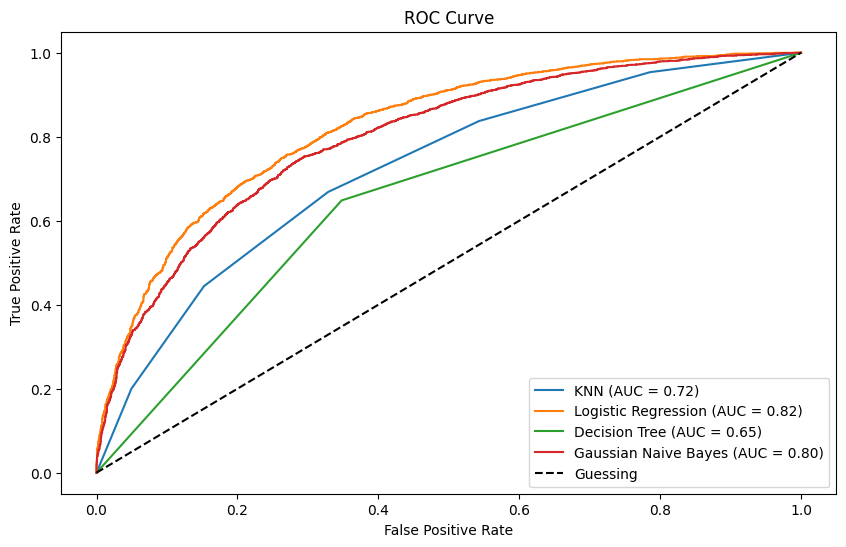

In [ ]:
model_list = {
    'KNN': model_knn,
    'Logistic Regression': model_log,
    'Decision Tree': model_tree,
    'Gaussian Naive Bayes': model_nb
}


plt.figure(figsize=(10, 6))
for model_name, model in model_list.items():
    model.fit(X_train, Y_train)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(Y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc= 'lower right')
plt.show()


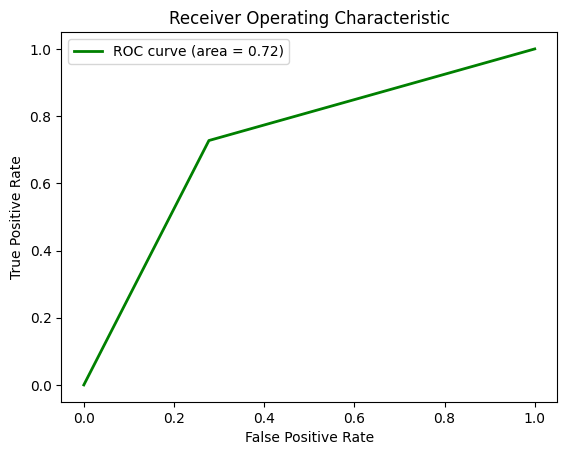

In [ ]:
# Find F1-score, Accuracy and AUC-ROC
y_pred = best_estimator.predict(X_test)
f1 = f1_score(Y_test, y_pred)
accuracy = accuracy_score(Y_test, y_pred)

# Graph the AUC-ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()